In [1]:
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

import scipy.stats
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from pygam import LinearGAM
from pygam.utils import generate_X_grid
from copy import copy
from progressbar import ProgressBar

# Forward Rate

## Smooth Spline Fit of the Forward Rate

100% (11 of 11) |#########################| Elapsed Time: 0:00:00 Time: 0:00:00


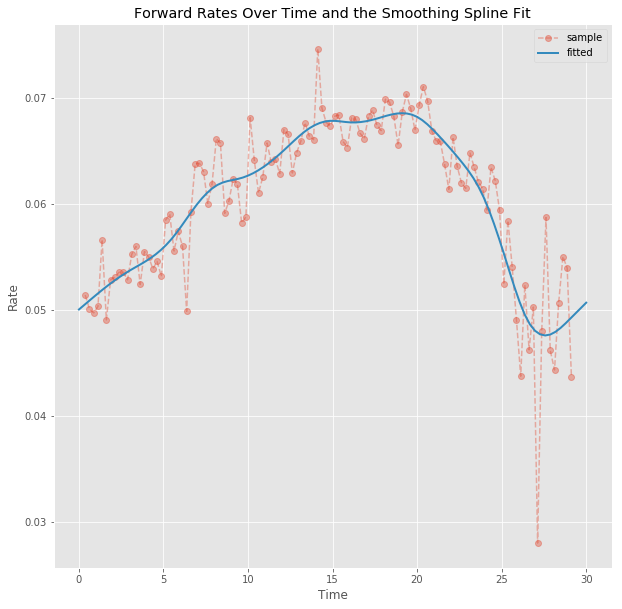

In [98]:
%%capture --no-stdout --no-display
gam = LinearGAM().gridsearch(x,y)

fig, ax = plt.subplots(1, 1, figsize=(10,10))
x_grid = np.linspace(0,30,100).reshape(100,1)
ax.plot(x,y,'o--', alpha=0.4, label='sample')
ax.plot(x_grid, gam.predict(x_grid), linewidth=2, label='fitted')
ax.update({'xlabel':'Time', 'ylabel':'Rate', 
           'title':'Forward Rates Over Time and the Smoothing Spline Fit'})
_ = ax.legend()

Yes, we obtain a fairly believable smooth fit.

## Splines are Nice for Integrals

The advantage of smoothing splines is that they are essentially piecewise cubic polynomial, which we can write down an explicit formula for (knowing the basis functions and the parameters with which they are linearly combined).

Then, integrating cublic polynomials becomes a piece of cake. We can just take advantage the linearity of integral: evaluate the integration for each piece of the spline, then add them together.

# Kernel Regression and Varying Smoothness

## $y$ Versus $x$

In [38]:
def mu(x):
    """
    ground truth: 
    y = { sin(x/2) on [0,4*pi] 
          sin(6*x) on [4*pi,8*pi] }
    """
    # 
    y = np.zeros(len(x))
    lefts, rights = (x<=4*np.pi), (x>4*np.pi)
    y[lefts] = np.sin(x[lefts]/2.0)
    y[rights] = np.sin(6*x[rights])
    return y

def generate_sample(n):
    # sample X uniformly on [0,8*pi].
    x = np.random.uniform(low=0, high=8*np.pi, size=n)
    x.sort()
    # sample Y as gaussians around mu(x)
    y = mu(x) + np.random.normal(loc=0, scale=0.2, size=n)
    return pd.DataFrame({'x':x, 'y':y})

scipy.random.seed(7)
sine_df = generate_sample(500)

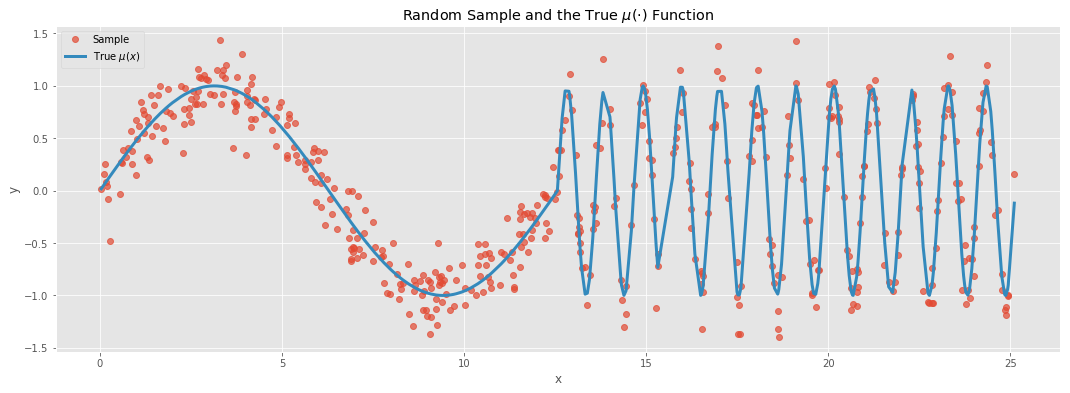

In [101]:
fig, ax = plt.subplots(1, 1, figsize=(18,6))
ax.plot(sine_df.x,sine_df.y, 'o', alpha=0.7, label='Sample')
ax.plot(sine_df.x,mu(sine_df.x), linewidth=3, label=r'True $\mu(x)$')
ax.update({'xlabel':'x', 'ylabel':'y', 
           'title':r'Random Sample and the True $\mu(\cdot)$ Function'})
_ = ax.legend()

The two parts of the data are very different. For $x>4 \pi$, $\mu$ is very wiggly. For $x\leq 4\pi$, it's a lot smoother.

## Different Parts of Data for CV

In [90]:
%%capture --no-stdout --no-display
left_df = sine_df[sine_df.x <= 4*np.pi]
right_df = sine_df[sine_df.x > 4*np.pi]
cv_lams = np.zeros(3)

for i, df in enumerate([left_df, right_df, sine_df]):
    x, y = df.x.values, df.y.values
    gam = LinearGAM(n_splines=100).gridsearch(
        x, y, lam=np.logspace(-5, 4, 100))
    cv_lams[i] = gam.lam
print('Selected lambdas: ', cv_lams)

100% (100 of 100) |#######################| Elapsed Time: 0:00:02 Time: 0:00:02
100% (100 of 100) |#######################| Elapsed Time: 0:00:02 Time: 0:00:02
100% (100 of 100) |#######################| Elapsed Time: 0:00:03 Time: 0:00:03


Selected lambdas:  [  1.87381742e+03   3.51119173e-01   2.84803587e-02]


The optimal $\lambda$'s are printed above. Let's call them $\lambda_{x\leq 4\pi}$, $\lambda_{x> 4\pi}$ and $\lambda_{all}$. We have

$$
\lambda_{x\leq 4\pi} > \lambda_{x\leq 4\pi} > \lambda_{all}
$$

This implies that fitting on the first part of data penalizes the most on the wiggliness of $\mu$, while fitting on the entire data set penalizes not that much, which results in a more flexible function.

## Varying Performance

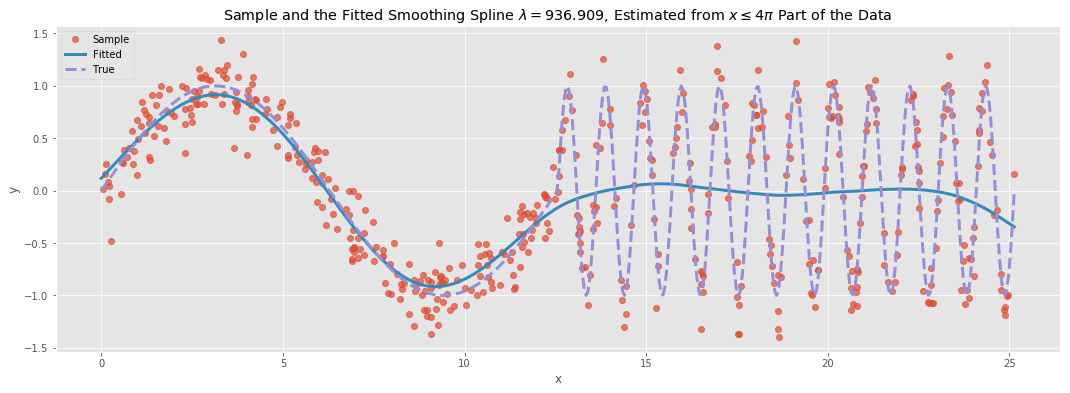

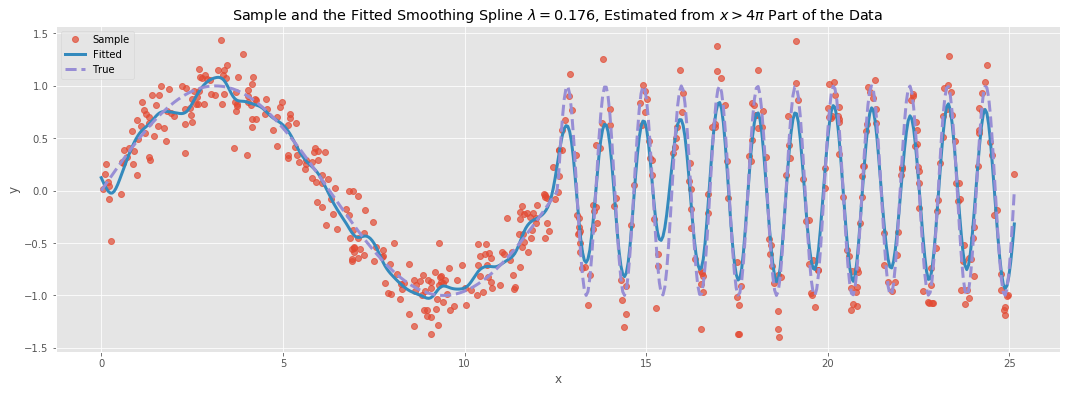

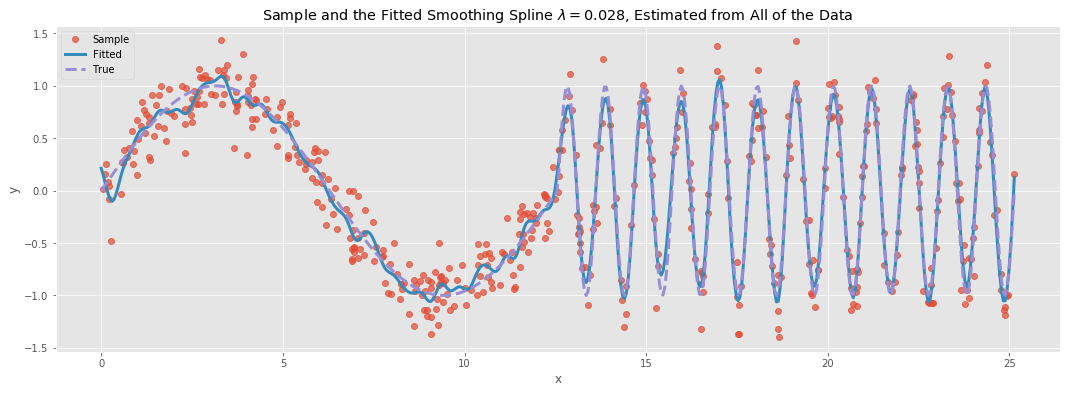

In [115]:
%%capture --no-stdout --no-display
adj_lams = copy(cv_lams); adj_lams[[0,1]] /= 2
for i, desc in enumerate([
    '$x\leq 4\pi$ Part', '$x>4\pi$ Part', 'All']):
    x, y = sine_df.x.values, sine_df.y.values
    gam = LinearGAM(
        n_splines=100, 
        lam=adj_lams[i]).fit(x, y)
    
    fig, ax = plt.subplots(1, 1, figsize=(18,6))
    x_grid = np.linspace(0,8*np.pi,500).reshape(500,1)
    ax.plot(x,y,'o', alpha=0.7, label='Sample')
    ax.plot(x_grid, gam.predict(x_grid), 
            linewidth=3, label='Fitted')
    ax.plot(x_grid, mu(x_grid.reshape(500,)), 
            '--', linewidth=3, label='True')
    ax.update({
        'xlabel':'x', 
        'ylabel':'y', 
        'title':'Sample and the Fitted Smoothing Spline '+
        r'$\lambda={}$, Estimated from {} of the Data'.format(
            round(adj_lams[i],3), desc)
    })
    ax.legend()

## Comparison

- The regression fitted on the **left** half of the data **underfits** the right half. As we seen in previous section, $\lambda_{x\leq 4\pi}$ turns out to be very large, and it demands a very flat spline fit, which is insufficient for the wiggly part of the data.


- The regression fitted on the **right** half of the data slightly **overfits** the left half. If we zoom in to the second plot, we will see many wiggles in the left part of the curve, which, of course, is a result of the small $\lambda_{x< 4\pi}$.


- The regression fitted on the whole data set seems to do well on the right half, but it still **overfits** the left half. In fact it is even more than the second case, since $\lambda_{all}$ is even smaller. This is an interesting result. I think it is because the parameter $\lambda$ is applied **Globally** to the optimization problem. Namely, if the sample is wiggly in a significant proportion of it, and the overall variance is not that large, then globally applying an large lambda turns out to not be a good idea. As a result, a small lambda will be chosen, and the overall fit will be more adapted to the most wiggly part of the function, making some compromise to the variance on its relatively flat part. But this might not be always true, there is always a trade-off.

# Additive Models for Prediction

In [2]:
train = pd.read_csv("bike_train.csv")
test = pd.read_csv("bike_test.csv")
X_names, y_name = list(train.columns[0:-1]),train.columns[-1]
X_train = train.iloc[:,0:-1].values
y_train = train.iloc[:,-1].values
X_test = test.iloc[:,0:-1].values
y_test = test.iloc[:,-1].values

## Linear Regression MSE

In [3]:
lm = LinearRegression().fit(X_train,y_train)
y_pred_lm = 1.6*lm.predict(X_test)
mse_lm = mean_squared_error(y_test, y_pred_lm)
print('MSE of linear regression is:', mse_lm)

MSE of linear regression is: 1295159.39451


## Linear GAM MSE

In [4]:
%%capture --no-stdout --no-display
gam = LinearGAM().gridsearch(
    X_train,y_train,lam=np.logspace(-5, 4, 100))
y_pred_gam = 1.6*gam.predict(X_test)
mse_gam = mean_squared_error(y_test, y_pred_gam)
print('MSE of linear GAM is:', mse_gam)

100% (100 of 100) |#######################| Elapsed Time: 0:00:05 Time: 0:00:05


MSE of linear GAM is: 967944.688091


## Partial Dependence of Linear GAM

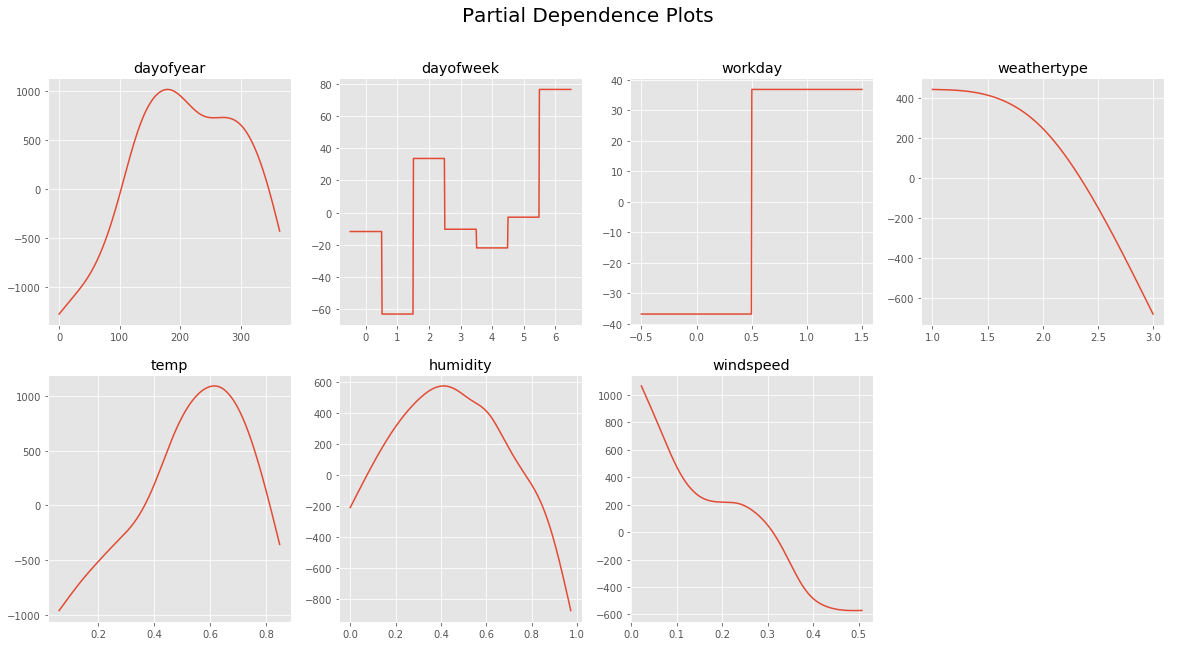

In [5]:
X_grid = generate_X_grid(gam)
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes[-1, -1].axis('off'); axes=axes.reshape(8)

for i, ax in enumerate(axes[0:len(X_names)]):
    pdep, confi = gam.partial_dependence(
        X_grid, feature=i+1, width=.95)
    ax.plot(X_grid[:, i], pdep)
    ax.set_title(X_names[i])
_ = fig.suptitle('Partial Dependence Plots', fontsize=20)

The partial dependence to `dayofyear`, `temp`, `humidity` has very obvious nonlinear shapes. These are the relationships that we are mostly likely to miss when using linear models.


**Interpretations**:
- `dayofyear`: The bike rental is active in the middle of the year, less active in winter and during holiday.
- `dayofweek`: Bike rental has an irregular distribution in a week, tend to be more of it on Saturday, much less on Monday.
- `workday`: In general, there's more bike rentals on weekdays than on weekends.
- `weathertype`: More bike rental on sunny days, less during the bad weathers.
- `temp`: Less bike rental when it's either too cold or too hot.
- `humidity`: Less bike rental when it's either too damp or too dry, which can be direct consequences of rainy/hot weathers.
- `windspeed`: Bike rental decrease with windspeed. A whole lot lessLess bike rental when it's blustery.

## True Loss

In [6]:
def real_loss(true, guess):
    return(np.mean(np.where(
        true>guess, 5*(true-guess), guess-true)))

L_lm = real_loss(y_test, y_pred_lm)
L_gam = real_loss(y_test, y_pred_gam)
print('Real loss of linear regression is:', L_lm)
print('Real loss of linear GAM is:', L_gam)

Real loss of linear regression is: 2412.83028509
Real loss of linear GAM is: 2075.47448558


## Quantile Adjustment

In [9]:
residual_lm = y_test - y_pred_lm
residual_gam = y_test - y_pred_gam
adj_lm = np.percentile(residual_lm, 100*5/6)
adj_gam = np.percentile(residual_gam, 100*5/6)
y_pred_lm_adj = y_pred_lm + adj_lm
y_pred_gam_adj = y_pred_gam + adj_gam

In [13]:
L_lm_adj = real_loss(y_test, y_pred_lm_adj)
L_gam_adj = real_loss(y_test, y_pred_gam_adj)
print('Real loss of linear regression (quantile adjusted) is:', L_lm_adj)
print('Real loss of linear GAM (quantile adjusted) is:', L_gam_adj)

Real loss of linear regression (quantile adjusted) is: 1429.4534003
Real loss of linear GAM (quantile adjusted) is: 1354.27558337


The performance of both estimators increases compared to the non-adjusted version of them. Yet the GAM estimator still outperforms the linear regression estimator. Therefore, my final choice is the quantile-adjusted GAM estimator.

# How Splines are Fitted